In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [2]:
#read CSV files
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")
# Merge customers with transactions to get the customer's transaction history
data= transactions_df.merge(customers_df, on='CustomerID')


In [3]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [4]:
data.dtypes

TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
CustomerName        object
Region              object
SignupDate          object
dtype: object

## one hot encoding

In [6]:
# Perform one-hot encoding on 'Region' and 'Category' columns
data = pd.get_dummies(data, columns=['Region'], drop_first=True)


In [7]:
# Convert boolean columns to integers
region_cols = ["Region_Europe", "Region_North America", "Region_South America"]
data[region_cols] = data[region_cols].astype(int)


In [8]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,SignupDate,Region_Europe,Region_North America,Region_South America
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,2022-12-03,1,0,0
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,2024-09-04,0,0,0
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,2024-04-04,1,0,0
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,2024-04-11,0,0,1
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,2022-03-15,1,0,0


## feature engineering


In [10]:
# feature engineering

data['SignupDate'] = pd.to_datetime(data['SignupDate'], errors='coerce')
today = pd.to_datetime('today')

# Calculate the difference in months
data['MonthsSinceSignup'] = (today.year - data['SignupDate'].dt.year) * 12 + today.month - data['SignupDate'].dt.month

# Display the result
data.head()



,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,SignupDate,Region_Europe,Region_North America,Region_South America,MonthsSinceSignup
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,2022-12-03,1,0,0,25
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,2024-09-04,0,0,0,4
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,2024-04-04,1,0,0,9
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,2024-04-11,0,0,1,9
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,2022-03-15,1,0,0,34


In [11]:

# Ensure TransactionDate is in datetime format
data["TransactionDate"] = pd.to_datetime(data["TransactionDate"])

# 1. Calculate 'days_since_last_transaction'
data["days_since_last_transaction"] = (pd.Timestamp("today") - data["TransactionDate"]).dt.days

# 2. Calculate 'transaction_count' for each customer
transaction_count = data.groupby("CustomerID")["TransactionID"].count().reset_index(name="transaction_count")

# Merge the transaction count back into the original DataFrame
data = pd.merge(data, transaction_count, on="CustomerID", how="left")

# Display the updated DataFrame
print(data.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName SignupDate  Region_Europe  \
0      300.68  300.68   Andrea Jenkins 2022-12-03              1   
1      300.68  300.68  Brittany Harvey 2024-09-04              0   
2      300.68  300.68  Kathryn Stevens 2024-04-04              1   
3      601.36  300.68  Travis Campbell 2024-04-11              0   
4      902.04  300.68    Timothy Perez 2022-03-15              1   

   Region_North America  Region_South America  MonthsSinceSignup  \
0                     0                     0                 25   
1                     0           

In [12]:
#drop unique identifier
data = data.drop(['TransactionID','ProductID','CustomerID',], axis=1)


## Feature Scaling

In [21]:


# Select relevant numerical features for scaling
numerical_features = data[['Quantity', 'TotalValue', 'Price','MonthsSinceSignup','days_since_last_transaction','transaction_count']]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max scaling to the numerical features
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Convert scaled features back to a DataFrame for easier handling
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_features.columns)




In [23]:
data.head()

,TransactionDate,Quantity,TotalValue,Price,CustomerName,SignupDate,Region_Europe,Region_North America,Region_South America,MonthsSinceSignup,days_since_last_transaction,transaction_count
0,2024-08-25 12:38:23,0.000000,0.144104,0.590849,Andrea Jenkins,2022-12-03,1,0,0,0.685714,0.343407,0.3
1,2024-05-27 22:23:54,0.000000,0.144104,0.590849,Brittany Harvey,2024-09-04,0,0,0,0.085714,0.587912,0.3
2,2024-04-25 07:38:55,0.000000,0.144104,0.590849,Kathryn Stevens,2024-04-04,1,0,0,0.228571,0.678571,0.5
3,2024-03-26 22:55:37,0.333333,0.296350,0.590849,Travis Campbell,2024-04-11,0,0,1,0.228571,0.758242,0.6
4,2024-03-21 15:10:10,0.666667,0.448596,0.590849,Timothy Perez,2022-03-15,1,0,0,0.942857,0.774725,0.3


## Selecting features for clustering


In [27]:
features = data[['Quantity', 'TotalValue','MonthsSinceSignup','days_since_last_transaction', 'transaction_count'] + [col for col in data.columns if 'Region_' in col]]

## Perform Clustering with KMeans

### Elbow Method for optimal clusters


C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

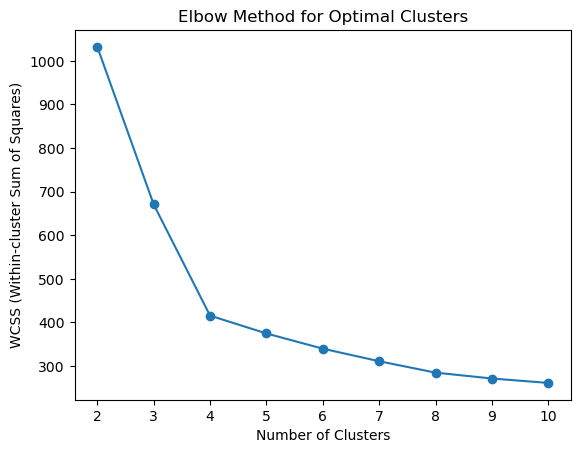

In [163]:
wcss = []
for i in range(2, 11):  # Testing for clusters between 2 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS for that k

# Plotting the elbow graph
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.show()




#### Fit KMeans 

In [159]:
kmeans = KMeans(n_clusters=4, random_state=42)
features['Cluster'] = kmeans.fit_predict(features)

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Hp\AppData\Local\Temp\ipykernel_23956\495881002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = kmeans.fit_predict(features)


### Evaluation Metrics


In [167]:
db_index = davies_bouldin_score(features, data['Cluster'])
silhouette_avg = silhouette_score(features, data['Cluster'])
wcss = kmeans.inertia_
print(f"WCSS (Within-cluster Sum of Squares): {wcss}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


WCSS (Within-cluster Sum of Squares): 261.39429442351906
Davies-Bouldin Index: 0.8011435579241639
Silhouette Score: 0.5193132188278329


### Visualise clusters using relevant plots.


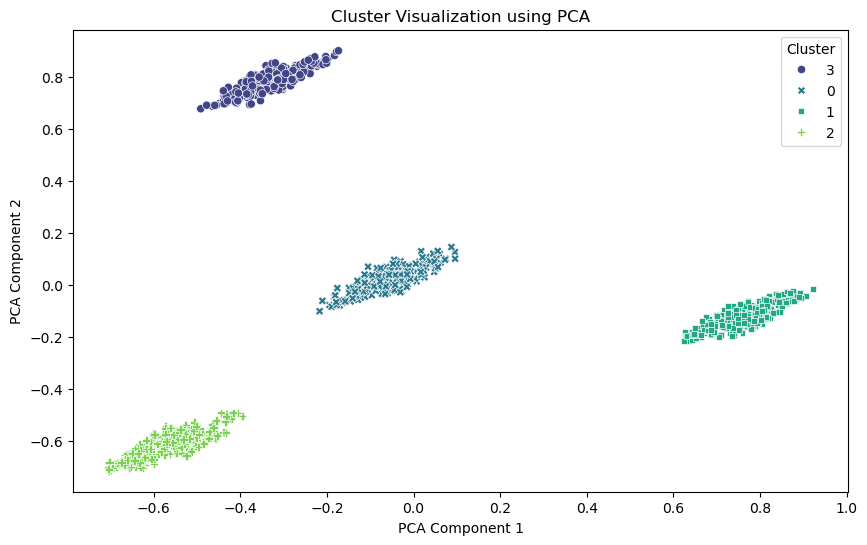

In [165]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_array)

# Scatter plot with PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=data['Cluster'],
    palette="viridis",
    style=data['Cluster'],  # Optional: Add different markers for each cluster
)
plt.title("Cluster Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()
